In [197]:
import os
import sys
import pandas as pd
import numpy as np
import re

current_dir = os.path.dirname(os.getcwd())
sys.path.append(current_dir)

In [2]:
from extract_kilter_holds import ExtractKilterHolds
from node_feature_extractor import NodeFeatureExtractor

In [112]:
raw_data_dir = os.path.join(os.path.dirname(os.getcwd()), 'raw')
climb_stats_csv_path = os.path.join(raw_data_dir, 'climb_stats.csv')
climb_cache_csv_path = os.path.join(raw_data_dir, 'climb_cache_fields.csv')
climbs_csv_path = os.path.join(raw_data_dir, 'climbs.csv')

df_climb_stats = pd.read_csv(climb_stats_csv_path)
df_climb_cache = pd.read_csv(climb_cache_csv_path)
df_climbs = pd.read_csv(climbs_csv_path)

df_climb_stats = df_climb_stats.rename(columns={'climb_uuid': 'uuid'})
df_climb_cache = df_climb_cache.rename(columns={'climb_uuid': 'uuid'})

print(df_climb_stats.shape)
print(df_climb_cache.shape)
print(df_climbs.shape)

(293126, 9)
(173703, 4)
(285263, 19)


In [205]:
df_all_climb_data = pd.merge(df_climb_stats, df_climb_cache, on='uuid')
df_all_climb_data = pd.merge(df_all_climb_data, df_climbs, on='uuid')

df_all_climb_data = df_all_climb_data[df_all_climb_data['frames_count'] == 1]
df_all_climb_data = df_all_climb_data[df_all_climb_data['frames_pace'] == 0]
df_all_climb_data = df_all_climb_data.drop(["benchmark_difficulty", "fa_username",
                                             "fa_at", "setter_username", 'description', 
                                             'created_at', 'is_nomatch',
                                             'frames_count', 'frames_pace',
                                             'display_difficulty_y', 'angle_y'], axis=1)


In [206]:
#df_all_climb_data[(df_all_climb_data['angle_x'] != df_all_climb_data['angle_y']) & 
#                  df_all_climb_data['angle_y'].notna()]

#df_all_climb_data[df_all_climb_data['uuid'] == '065CAF74B4BC463B9D550750181F89D4']
df_all_climb_data.shape

(291751, 19)

In [207]:
#GECKO BOARD
df_gecko_climb_data = df_all_climb_data[df_all_climb_data['layout_id'] == 1].copy()
print(df_gecko_climb_data.shape)
df_gecko_climb_data = df_gecko_climb_data[df_gecko_climb_data["edge_top"] < 160]
print(df_gecko_climb_data.shape)
df_gecko_climb_data = df_gecko_climb_data[df_gecko_climb_data["edge_right"] < 142]
print(df_gecko_climb_data.shape)
df_gecko_climb_data = df_gecko_climb_data[df_gecko_climb_data["edge_left"] > 0]
print(df_gecko_climb_data.shape)

#Is Listed
df_gecko_climb_data = df_gecko_climb_data[df_gecko_climb_data["is_listed"] == 1]
print(df_gecko_climb_data.shape)

#Drop more columns
df_gecko_climb_data = df_gecko_climb_data.drop(['is_draft','is_listed',
                                            'edge_left', 'edge_right',
                                            'edge_top', 'edge_bottom',
                                            'setter_id', 'layout_id'], axis=1)


(253075, 19)
(252897, 19)
(250195, 19)
(247995, 19)
(235309, 19)


In [208]:
gecko_climbs_csv_path = os.path.join(os.path.dirname(os.getcwd()), 'gecko_climbs.csv')
all_climb_csv_path = os.path.join(os.path.dirname(os.getcwd()), 'all_climbs.csv')

df_gecko_climb_data.to_csv(gecko_climbs_csv_path, index=False)
df_all_climb_data.to_csv(all_climb_csv_path, index=False)

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\mdaman\\CodeProjects\\ai_Kilter_Routes\\data\\gecko_climbs.csv'

Climb hold colors reset to default.
Climb hold type reset to default.
Data loaded and preprocessed successfully.
Climb hold colors reset to default.
Climb hold type reset to default.
Custom colors and types applied.


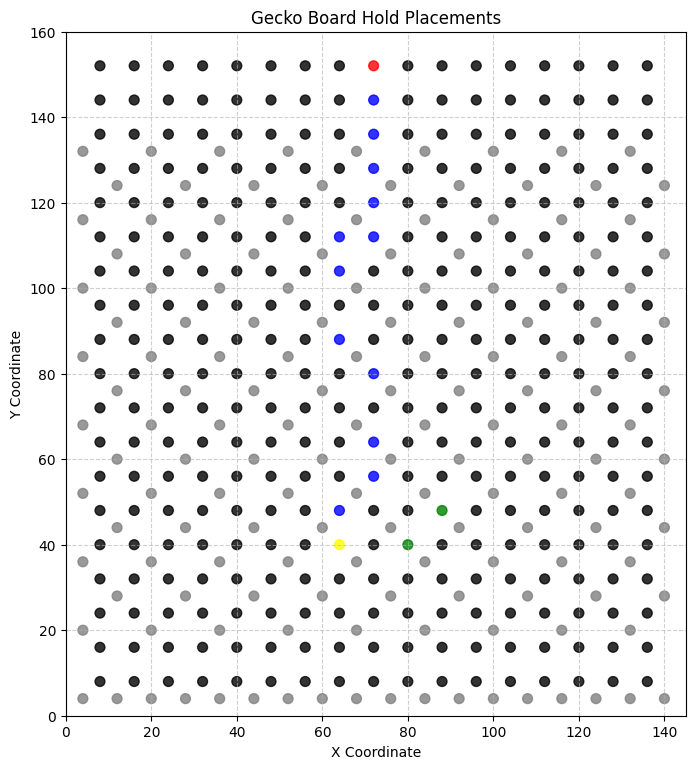

the blake


In [209]:
raw_data_dir = os.path.join(os.path.dirname(os.getcwd()), 'raw')
holds = ExtractKilterHolds(raw_data_dir)

i = 1
my_string = df_gecko_climb_data['frames'][i]

holds.apply_climb(my_string)

holds.plot_gecko_board()

print(df_gecko_climb_data['name'][i])

Loaded data from climbing route dataframe
Filtered data for Gecko board.
Normalized 'x' and 'y' coordinates.
One-hot encoded categorical columns: ['default_hold_color', 'climb_hold_type']
Populated node features dictionary.
Created node feature dataframe and matrix.


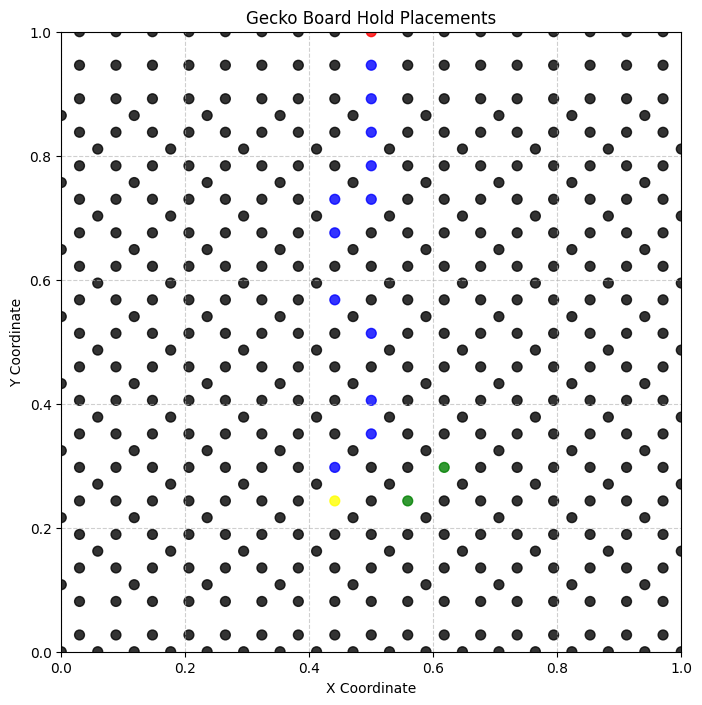

In [210]:
extractor = NodeFeatureExtractor(holds.gecko_board_df)
extractor.plot_board()

In [306]:
#Drop rows for some climbs
print(df_gecko_climb_data.shape)
df_gecko_climb_data_filtered = df_gecko_climb_data[df_gecko_climb_data['ascensionist_count_y'] > 10].copy()
print(df_gecko_climb_data_filtered.shape)
df_gecko_climb_data_filtered = df_gecko_climb_data_filtered[df_gecko_climb_data_filtered['ascensionist_count_x'] > 5].copy()
print(df_gecko_climb_data_filtered.shape)
df_gecko_climb_data_filtered = df_gecko_climb_data_filtered[df_gecko_climb_data_filtered['quality_average_y'] > 2].copy()
print(df_gecko_climb_data_filtered.shape)
df_gecko_climb_data_filtered = df_gecko_climb_data_filtered[df_gecko_climb_data_filtered['quality_average_x'] > 2].copy()
print(df_gecko_climb_data_filtered.shape)

(235309, 11)
(76589, 11)
(40396, 11)
(40343, 11)
(40156, 11)


In [278]:
#Similiarity Score

df_similarity = df_gecko_climb_data_filtered.drop(['angle_x', 'ascensionist_count_x', 'display_difficulty_x',
                                          'difficulty_average', 'quality_average_x', 'ascensionist_count_y',
                                          'quality_average_y', 'hsm'], axis=1).copy()
df_similarity = df_similarity.drop_duplicates(subset=['uuid'], keep='first')
df_similarity = df_similarity.reset_index(drop=True)
df_similarity['frames'] = df_similarity['frames'].astype(str).fillna('')

pattern = r'p(\d{4})(r\d{2})'

def extract_and_filter_holds(frames_string):
    extracted_pairs = re.findall(pattern, frames_string)
    relevant_holds = []
    for hold, hold_type in extracted_pairs:
        if hold_type in ['r12', 'r13', 'r14']:
            relevant_holds.append(hold)
    return relevant_holds

df_similarity['hand_holds'] = df_similarity['frames'].apply(extract_and_filter_holds)

# You can now print the head of the DataFrame to see the new column
print(df_similarity.head())
print(df_similarity.shape)

                               uuid                    name  \
0  000B9FE6383B425EB74A977273F4E4DC        Abradolf Lincler   
1  0031FF8875E9464986436BCC8BA2D99A                     smd   
2  0047d90951b5425dbf64572bef3e8593               coaticook   
3  0283a78adcfc4a01b21b2009e0f9b88a  Töl. Ja wo is er denn?   
4  03D016DD2A8D4BF88B6F408FA6D95DD0             baby Zach 👶   

                                              frames  \
0  p1073r15p1172r12p1241r13p1271r13p1322r13p1371r...   
1  p1081r15p1083r15p1129r12p1147r12p1183r13p1215r...   
2  p1108r12p1129r12p1178r13p1246r13p1284r13p1320r...   
3  p1239r12p1276r12p1304r13p1340r13p1370r13p1381r...   
4  p1187r12p1201r12p1256r13p1304r13p1357r13p1389r...   

                                          hand_holds  
0         [1172, 1241, 1271, 1322, 1371, 1389, 1518]  
1  [1129, 1147, 1183, 1215, 1229, 1230, 1301, 133...  
2   [1108, 1129, 1178, 1246, 1284, 1320, 1323, 1387]  
3         [1239, 1276, 1304, 1340, 1370, 1381, 1385]  
4        

In [279]:
#Jaccard Similarity

def jaccard_similarity(list1, list2):
    """
    Calculates the Jaccard Similarity between two lists.
    Returns 1.0 if both lists are empty.
    """
    set1 = set(list1)
    set2 = set(list2)

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    if union == 0:
        return 1.0  # Both sets are empty, considered perfectly similar
    return intersection / union


all_hand_holds_lists = df_similarity['hand_holds'].tolist()
num_rows = len(all_hand_holds_lists)

similarity_matrix = np.zeros((num_rows, num_rows))

for i in range(num_rows):
    for j in range(num_rows):
        similarity_matrix[i, j] = jaccard_similarity(
            all_hand_holds_lists[i], all_hand_holds_lists[j]
        )

similarity_df = pd.DataFrame(similarity_matrix,
                             index=df_similarity['uuid'], # Use 'uuid' for clear labels
                             columns=df_similarity['uuid']) # Use 'uuid' for clear labels

print("\nJaccard Similarity Matrix for 'hand_holds' column (all rows vs. all rows):")
print(similarity_df)



Jaccard Similarity Matrix for 'hand_holds' column (all rows vs. all rows):
uuid                              000B9FE6383B425EB74A977273F4E4DC  \
uuid                                                                 
000B9FE6383B425EB74A977273F4E4DC                          1.000000   
0031FF8875E9464986436BCC8BA2D99A                          0.000000   
0047d90951b5425dbf64572bef3e8593                          0.000000   
0283a78adcfc4a01b21b2009e0f9b88a                          0.000000   
03D016DD2A8D4BF88B6F408FA6D95DD0                          0.083333   
...                                                            ...   
2B101D5684BE4F6EA6679D285E1D5CC2                          0.000000   
E22FCC6DB55F45E7B2D6B604698ACCFC                          0.000000   
8DEC0218173C4537B637F8CE0959D207                          0.000000   
E2F41EA8A91F4590AE5A20D425076EF5                          0.000000   
779B07D892C24055A19BC2FF643A1613                          0.000000   

uuid         

In [280]:
similarity_threshold = 0.8

high_similarity_pairs = []
uuids = similarity_df.index.tolist() # Get the list of all UUIDs (row/column labels)
num_uuids = len(uuids)

for i in range(num_uuids):
    for j in range(i + 1, num_uuids): # Start j from i+1
        uuid1 = uuids[i]
        uuid2 = uuids[j]
        score = similarity_df.loc[uuid1, uuid2] # Get the similarity score

        if score >= similarity_threshold:
            high_similarity_pairs.append((uuid1, uuid2, score))

# Sort the pairs by similarity score in descending order for better readability
high_similarity_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\n--- UUID pairs with Jaccard Similarity score >= {similarity_threshold:.2f} ---")
if high_similarity_pairs:
    for pair in high_similarity_pairs:
        print(f"  {pair[0]} <-> {pair[1]} (Score: {pair[2]:.4f})")
else:
    print("No pairs found above the specified similarity threshold.")


--- UUID pairs with Jaccard Similarity score >= 0.80 ---
  1d5f6090d439424e960c19a63f22f437 <-> 4191fc5de38e4f728c8f5e4535cb466a (Score: 1.0000)
  926C6E7A7F8742C58A958460C9D150F8 <-> 09C90CA5B33043EA841ED79C01B13BC8 (Score: 1.0000)
  003798C0E9BE4744A30D7482BC44D872 <-> 6b6eca0ae6d941e0a73732454f743c2e (Score: 1.0000)
  2E1403ADA88D4A1D8824A16A5A380B3C <-> 38012EB856DA47E6894260CEC14DBC87 (Score: 1.0000)
  25781A4D802A498EA1562EBB14DCFC7F <-> 5201868B85EF4DCC84C7BD2E83360EA9 (Score: 1.0000)
  4A30649DDFEB4A20BA2EC121343EAC60 <-> 5854E2D72D5441DB8DCE8E9A89D8A33D (Score: 1.0000)
  9A000CE4CD3B47C39DF723B0405B485B <-> 3A9ADFCEFC1C403C942F95A49849692D (Score: 1.0000)
  BFFD3CA35F704ECA9A24B89D757EC1D8 <-> 2bcbfcdd1fdb4014bee91b1048822ba1 (Score: 1.0000)
  f26eb7d0fbed4c7d8d56423d545d2c29 <-> c4a875de77fb47fb9a0dab29e4c509f3 (Score: 1.0000)
  E61998C770F34BE189901E62E26C643F <-> 9dcb4acf19d0438a983be10fad882e4d (Score: 1.0000)
  0a73ce0f15d04857a8b4ee7c822025bb <-> da8d33a507db41b3ab77431

In [309]:
len(high_similarity_pairs)

935

In [312]:
print(df_gecko_climb_data_filtered.shape)

# Create a set to store UUIDs that we've decided to remove
uuids_to_remove = set()

# It's crucial to iterate over a copy or pre-process if the list of pairs
# itself might contain overlapping UUIDs that could lead to double-removal logic issues.
# For simplicity, we'll assume high_similarity_pairs is generated once and represents
# distinct comparison pairs.

for climb_one_uuid, climb_two_uuid, jaccard_score in high_similarity_pairs:
    # Ensure both UUIDs are still present in our working DataFrame
    # This handles cases where one of the UUIDs might have already been removed
    # due to a previous pair comparison.
    is_climb_one_present = climb_one_uuid in df_gecko_climb_data_filtered['uuid'].values
    is_climb_two_present = climb_two_uuid in df_gecko_climb_data_filtered['uuid'].values

    if not is_climb_one_present and not is_climb_two_present:
        continue # Both already removed, move to next pair
    elif not is_climb_one_present:
        # Climb one already removed, implicitly means climb two "won" or wasn't compared
        # in a way that removed it.
        # No action needed for this pair regarding climb_one.
        continue # Or you might decide to remove climb_two if it's the only one left and was "similar" to a previously removed one.
                 # This logic depends on your exact de-duplication strategy.
    elif not is_climb_two_present:
        # Climb two already removed
        continue # Similar logic as above

    # Safely get quality values
    # Use .loc to ensure we get a Series and then .item() to get the scalar value
    try:
        climb_one_quality = df_gecko_climb_data_filtered.loc[df_gecko_climb_data_filtered['uuid'] == climb_one_uuid, 'quality_average_y'].item()
        climb_two_quality = df_gecko_climb_data_filtered.loc[df_gecko_climb_data_filtered['uuid'] == climb_two_uuid, 'quality_average_y'].item()
    except ValueError:
        # This can happen if .item() is called on an empty Series (e.g., if a UUID was removed previously)
        # or on a Series with multiple items (which shouldn't happen if UUID is truly unique).
        # We handle the case where a UUID might have been removed already.
        # If one of them is already gone, we just skip this pair for comparison purposes.
        print(f"Skipping pair ({climb_one_uuid}, {climb_two_uuid}) as one or both UUIDs might be missing.")
        continue


    if climb_one_quality > climb_two_quality:
        uuids_to_remove.add(climb_two_uuid)
    elif climb_two_quality > climb_one_quality: # Explicitly check if climb_two is greater
        uuids_to_remove.add(climb_one_uuid)
    else:
        # Handle ties: if qualities are equal, you need a tie-breaking rule.
        # For example, remove climb_two (arbitrary), or the one that appeared second in your pair list.
        # For now, let's remove climb_two in case of a tie.
        uuids_to_remove.add(climb_two_uuid)
        print(f"Qualities are equal for {climb_one_uuid} and {climb_two_uuid}. Removing {climb_two_uuid}.")

df_gecko_climb_data_filtered = df_gecko_climb_data_filtered[~df_gecko_climb_data_filtered['uuid'].isin(uuids_to_remove)]

(40156, 11)
Skipping pair (1d5f6090d439424e960c19a63f22f437, 4191fc5de38e4f728c8f5e4535cb466a) as one or both UUIDs might be missing.
Skipping pair (926C6E7A7F8742C58A958460C9D150F8, 09C90CA5B33043EA841ED79C01B13BC8) as one or both UUIDs might be missing.
Skipping pair (003798C0E9BE4744A30D7482BC44D872, 6b6eca0ae6d941e0a73732454f743c2e) as one or both UUIDs might be missing.
Skipping pair (2E1403ADA88D4A1D8824A16A5A380B3C, 38012EB856DA47E6894260CEC14DBC87) as one or both UUIDs might be missing.
Skipping pair (25781A4D802A498EA1562EBB14DCFC7F, 5201868B85EF4DCC84C7BD2E83360EA9) as one or both UUIDs might be missing.
Skipping pair (9A000CE4CD3B47C39DF723B0405B485B, 3A9ADFCEFC1C403C942F95A49849692D) as one or both UUIDs might be missing.
Skipping pair (BFFD3CA35F704ECA9A24B89D757EC1D8, 2bcbfcdd1fdb4014bee91b1048822ba1) as one or both UUIDs might be missing.
Skipping pair (f26eb7d0fbed4c7d8d56423d545d2c29, c4a875de77fb47fb9a0dab29e4c509f3) as one or both UUIDs might be missing.
Skipping pai

In [313]:
print(df_gecko_climb_data_filtered.shape)

(40044, 11)
